In [26]:
import pandas as pd 

info_df = pd.read_csv('info_trans_with_punctuation_cleaned.csv')
mis_df = pd.read_csv('misinfo_trans_with_punctuation_cleaned.csv')

info_df.head(5)

,ID,transcript_with_punctuation
0,do8O1YxzdVg,"if you don't like eating veggies, this video i..."
1,bpsKYwQffes,"if you are not freezing your rice, this is you..."
2,9RO83PiuQ-A,if you don't like cooking and washing dishes b...
3,dI-Be4IehyQ,"you've heard of sheep pan dinners, but have yo..."
4,O_7ZvwhzqGg,"if you like salads but hate preparing them, th..."


### Clean Data

In [27]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification  # Commented out for now (assuming PyTorch)
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def tokenize_text(text):
  encoded_text = tokenizer(text, return_tensors="pt")  # Convert to PyTorch tensors
  return encoded_text

info_df['encoded_text'] = info_df['transcript_with_punctuation'].apply(tokenize_text)

import torch


def predict_sentiment(encoded_text):
  with torch.no_grad():  # Disable gradient calculation for efficiency
    output = model(**encoded_text)
    predictions = torch.nn.functional.softmax(output.logits, dim=-1)  # Get probabilities
    # Find the index of the class with the highest probability
    predicted_class_idx = torch.argmax(predictions, dim=1).item()
    # Get the label using the model configuration
    predicted_label = config.id2label[predicted_class_idx] if config is not None else "unknown"
    return predicted_label, predictions[:, 1].item()  # Return label and positive class probability

# Add a new column for probability
info_df['sentiment_probability'] = np.nan  # Initialize with NaN values
info_df['sentiment'] = info_df['encoded_text'].apply(lambda x: predict_sentiment(x)[0])

# Access elements from the dictionary within lambda function
def g(x):
  encoded_dict = x['encoded_text']
  model_input = {'input_ids': encoded_dict['input_ids'], 'attention_mask': None}
  label, probability = predict_sentiment(model_input)
  x['sentiment'] = label
  # Update sentiment_probability directly in the row
  x['sentiment_probability'] = probability
  return x

info_df.update(info_df[['encoded_text']].apply(g, axis=1))

info_df

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,ID,transcript_with_punctuation,encoded_text,sentiment_probability,sentiment
0,do8O1YxzdVg,"if you don't like eating veggies, this video i...","[input_ids, attention_mask]",0.370416,negative
1,bpsKYwQffes,"if you are not freezing your rice, this is you...","[input_ids, attention_mask]",0.573456,neutral
2,9RO83PiuQ-A,if you don't like cooking and washing dishes b...,"[input_ids, attention_mask]",0.313569,positive
3,dI-Be4IehyQ,"you've heard of sheep pan dinners, but have yo...","[input_ids, attention_mask]",0.088705,positive
4,O_7ZvwhzqGg,"if you like salads but hate preparing them, th...","[input_ids, attention_mask]",0.600128,neutral
...,...,...,...,...,...
721,h1HN1mUtlBE,"here's what your favorite foods say about you,...","[input_ids, attention_mask]",0.573707,neutral
722,0pCBZYrGWqY,hear my thoughts on nutrition Trends and fads ...,"[input_ids, attention_mask]",0.750411,neutral
723,wkvxzcQEXoE,"do you need a super simple, thinner, and I mea...","[input_ids, attention_mask]",0.658251,neutral
724,9r3uCzlBHIg,I'm a dietitian and a mom who does baby lead w...,"[input_ids, attention_mask]",0.653318,neutral


sentiment_probability: probability of the text belonging to each sentiment category

In [28]:
mis_df['encoded_text'] = mis_df['transcript_with_punctuation'].apply(tokenize_text)
mis_df['sentiment_probability'] = np.nan  # Initialize with NaN values
mis_df['sentiment'] = mis_df['encoded_text'].apply(lambda x: predict_sentiment(x)[0])
mis_df.update(mis_df[['encoded_text']].apply(g, axis=1))
mis_df

,ID,transcript_with_punctuation,encoded_text,sentiment_probability,sentiment
0,zqdxQWTdIM4,I'm going to show you the absolute best natura...,"[input_ids, attention_mask]",0.471503,neutral
1,aYV9EWaiz_Y,I'm going to give you three tips to help you l...,"[input_ids, attention_mask]",0.382934,positive
2,G4guVvCYAEA,the absolute number one most inflammatory food...,"[input_ids, attention_mask]",0.165083,negative
3,u0-U3-f4VHM,"you know, if you went to your kitchen right no...","[input_ids, attention_mask]",0.416922,positive
4,llDg68l626M,"all right, we're at our favorite restaurant, K...","[input_ids, attention_mask]",0.076333,positive
...,...,...,...,...,...
1252,3SHtxj9nRpM,here are the top 5 foods to stay away from in ...,"[input_ids, attention_mask]",0.261021,negative
1253,9eeNkQNtfxY,are you looking to improve your diet but don't...,"[input_ids, attention_mask]",0.421491,positive
1254,PdLrENnDPbA,here are five simple steps to help you create ...,"[input_ids, attention_mask]",0.307707,positive
1255,ffF45hF4NV0,"chase your dreams, not excuses. stop making re...","[input_ids, attention_mask]",0.219639,positive


In [45]:
mis_df[(mis_df['sentiment'] == 'positive')].sort_values('sentiment_probability')

,ID,transcript_with_punctuation,encoded_text,sentiment_probability,sentiment,is_informative
202,GfwPPsTjdgQ,I love vegan food. this beautiful Majestic cre...,"[input_ids, attention_mask]",0.008257,positive,0
633,8I-GpwFe5Fg,"Thanksgiving is about being grateful, and toda...","[input_ids, attention_mask]",0.017861,positive,0
561,YH2yLu68OIk,I made a meat stick with organs- the first of ...,"[input_ids, attention_mask]",0.020377,positive,0
814,dfNxRQ766ic,"coconut oil is great. it's not an animal fat, ...","[input_ids, attention_mask]",0.021623,positive,0
1230,fqoiy0HL5oU,three amazing things that will happen when you...,"[input_ids, attention_mask]",0.022849,positive,0
...,...,...,...,...,...,...
407,GR4Ql0leUCo,doc Sean Baker here again. let's give you some...,"[input_ids, attention_mask]",0.475023,positive,0
167,BQi5wh7-30I,so a compound known as carnosine is found in R...,"[input_ids, attention_mask]",0.477308,positive,0
805,NTsKlN5MzLM,McDonald's used to use Tallow in their fryers-...,"[input_ids, attention_mask]",0.477403,positive,0
58,B1D7bjFMPC4,people that have a slow metabolism actually ha...,"[input_ids, attention_mask]",0.478703,positive,0


In [46]:
mis_df.sort_values('sentiment_probability')

,ID,transcript_with_punctuation,encoded_text,sentiment_probability,sentiment,is_informative
202,GfwPPsTjdgQ,I love vegan food. this beautiful Majestic cre...,"[input_ids, attention_mask]",0.008257,positive,0
633,8I-GpwFe5Fg,"Thanksgiving is about being grateful, and toda...","[input_ids, attention_mask]",0.017861,positive,0
561,YH2yLu68OIk,I made a meat stick with organs- the first of ...,"[input_ids, attention_mask]",0.020377,positive,0
814,dfNxRQ766ic,"coconut oil is great. it's not an animal fat, ...","[input_ids, attention_mask]",0.021623,positive,0
1230,fqoiy0HL5oU,three amazing things that will happen when you...,"[input_ids, attention_mask]",0.022849,positive,0
...,...,...,...,...,...,...
272,9A0dO_KRo3E,"okay, after doing the last video on the macron...","[input_ids, attention_mask]",0.854389,neutral,0
500,anh6a--sZPI,okay under the watchful eye of Maximus the coa...,"[input_ids, attention_mask]",0.857375,neutral,0
280,jvMw4aoiK1E,"okay, people are asking to ask me: you know ab...","[input_ids, attention_mask]",0.858848,neutral,0
388,oAngmesFo_c,"in a previous video, we talked about Foods you...","[input_ids, attention_mask]",0.875639,neutral,0


In [29]:
mis_df['is_informative'] = int(False)
info_df['is_informative'] = int(True)

combined_df = pd.concat([mis_df, info_df], ignore_index=True)
combined_df

,ID,transcript_with_punctuation,encoded_text,sentiment_probability,sentiment,is_informative
0,zqdxQWTdIM4,I'm going to show you the absolute best natura...,"[input_ids, attention_mask]",0.471503,neutral,0
1,aYV9EWaiz_Y,I'm going to give you three tips to help you l...,"[input_ids, attention_mask]",0.382934,positive,0
2,G4guVvCYAEA,the absolute number one most inflammatory food...,"[input_ids, attention_mask]",0.165083,negative,0
3,u0-U3-f4VHM,"you know, if you went to your kitchen right no...","[input_ids, attention_mask]",0.416922,positive,0
4,llDg68l626M,"all right, we're at our favorite restaurant, K...","[input_ids, attention_mask]",0.076333,positive,0
...,...,...,...,...,...,...
1978,h1HN1mUtlBE,"here's what your favorite foods say about you,...","[input_ids, attention_mask]",0.573707,neutral,1
1979,0pCBZYrGWqY,hear my thoughts on nutrition Trends and fads ...,"[input_ids, attention_mask]",0.750411,neutral,1
1980,wkvxzcQEXoE,"do you need a super simple, thinner, and I mea...","[input_ids, attention_mask]",0.658251,neutral,1
1981,9r3uCzlBHIg,I'm a dietitian and a mom who does baby lead w...,"[input_ids, attention_mask]",0.653318,neutral,1


Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

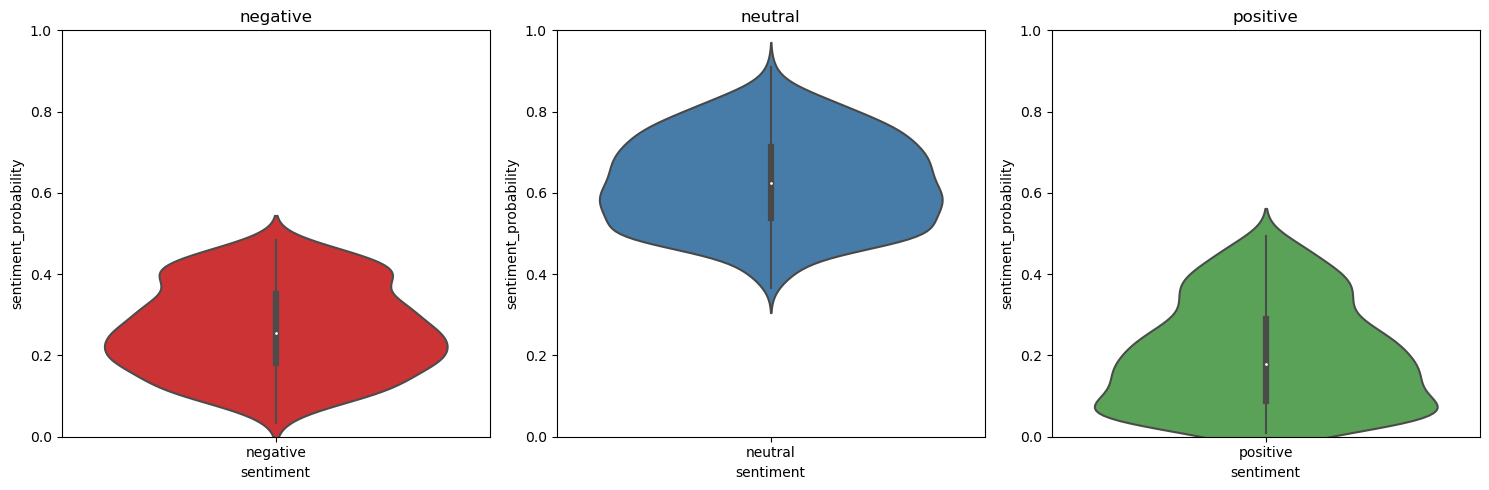

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

sentiment_categories = combined_df['sentiment'].unique()  # Get unique sentiment categories

# Define a color palette for the plots
palette = sns.color_palette("Set1", len(sentiment_categories))  # Adjust palette as desired

desired_order = ["negative", "neutral", "positive"]  # Define your desired order

for i, category in enumerate(desired_order):
    data_subset = combined_df[combined_df['sentiment'] == category]
    sns.violinplot(x = "sentiment", y = "sentiment_probability", showmeans=True, data=data_subset, ax=axes[i], color=palette[i])
    axes[i].set_title(category)
    axes[i].set_ylim(0, 1)

plt.tight_layout()  # Adjust spacing between plots
plt.show()

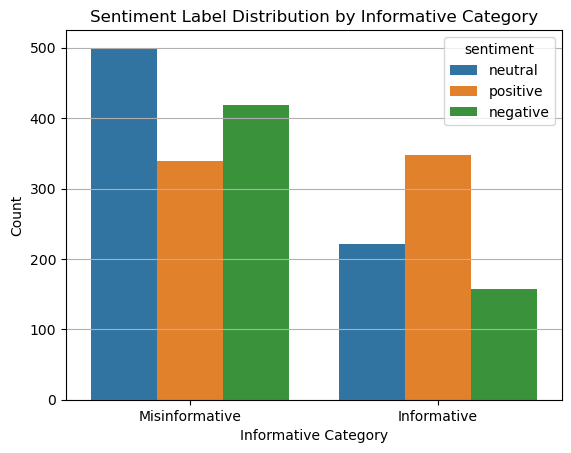

In [31]:
# Create a normalized bar plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot using seaborn
sns.countplot(x = "is_informative", hue="sentiment", data=combined_df)
plt.xlabel('Informative Category')
plt.ylabel('Count')
plt.title('Sentiment Label Distribution by Informative Category')
plt.xticks(ticks=[0, 1], labels = ['Misinformative', 'Informative'])
plt.grid(axis='y')
plt.show()

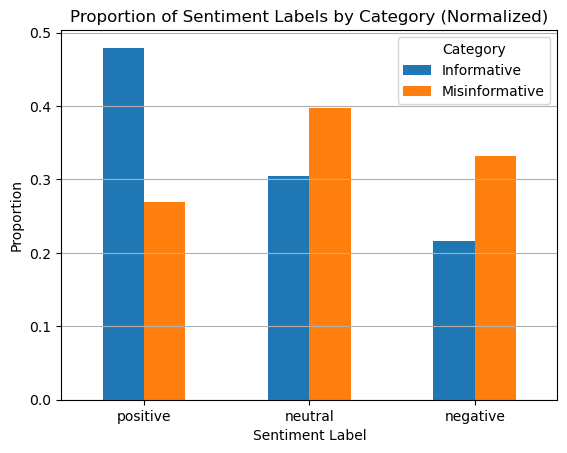

In [40]:
import pandas as pd

# Calculate proportions for each sentiment label within each group
informative_df = combined_df[combined_df['is_informative'] == 1]
misinformative_df = combined_df[combined_df['is_informative'] == 0]

informative_proportions = informative_df['sentiment'].value_counts(normalize=True)
misinformative_proportions = misinformative_df['sentiment'].value_counts(normalize=True)

# Concatenate informative and misinformative proportions into a single DataFrame
sentiment_proportions = pd.concat([informative_proportions, misinformative_proportions], keys=['Informative', 'Misinformative'], axis=1)

# Create a bar plot with separate bars for each group and calculated proportions
sentiment_proportions.plot(kind='bar', stacked=False)  # Set stacked=False to avoid stacking
plt.xlabel('Sentiment Label')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment Labels by Category (Normalized)')
plt.legend(title='Category')  # Adjust legend title
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [10]:
import numpy as np 
from scipy import stats

info_scores = combined_df[combined_df['is_informative'] == 1]['sentiment']
mis_scores = combined_df[combined_df['is_informative'] == 0]['sentiment']

t_statistic, p_value = stats.ttest_ind(info_scores, mis_scores)

# Print the results
print(f"T statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

T statistic: 6.0712
p-value: 0.0000


In [11]:
u_statistic, p_value = stats.mannwhitneyu(info_scores, mis_scores)
# Print the results
print(f"U statistic: {u_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

U statistic: 528510.0000
p-value: 0.0000
